## Keras autoencoder自编码

自编码，简单来说就是把输入数据进行一个压缩和解压缩的过程。 原来有很多 Feature，压缩成几个来代表原来的数据，解压之后恢复成原来的维度，再和原数据进行比较。
它是一种非监督算法，只需要输入数据，解压缩之后的结果与原数据本身进行比较。

使用mnist 数据集，把 28×28＝784 维的数据，压缩成 2 维的数据，然后在一个二维空间中可视化出分类的效果。

In [4]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# download the mnist to the path '~/.keras/datasets/' if it is the first time to be called
# X shape (60,000 28x28), y shape (10,000, )
(X_train, _), (X_test, y_test) = mnist.load_data()

# data pre-processing
X_train = X_train.astype('float32') / 255. - 0.5       # minmax_normalized
X_test = X_test.astype('float32') / 255. - 0.5         # minmax_normalized
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [6]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

### 建立模型
**encoder**
* encoding_dim，要压缩成的维度。
* 接下来是建立 encoded 和 decoded ，再用 autoencoder 把二者组建在一起。训练时用 autoencoder。
* encoded 用4层 Dense 全联接层，激活函数用 relu，输入的维度就是前一步定义的 input_img。
* 接下来定义下一层，它的输出维度是64，输入是上一层的输出结果。在最后一层，我们定义它的输出维度就是想要的 encoding_dim＝2。

**decoder**

解压的环节，它的过程和压缩的过程是正好相反的。相对应层的激活函数也是一样的，不过在解压的最后一层用到的激活函数是 tanh。 因为输入值是由 -0.5 到 0.5 这个范围，在最后一层用这个激活函数的时候，它的输出是 -1 到 1，可以是作为一个很好的对应。

In [13]:
# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(784,))
# encoder layers
encoded = Dense(128, activation='relu')(input_img)  # 128代表这层的输出值，输入值是括号内的input_img
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)  # 反向输入encoder_output
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='tanh')(decoded)  # 解压范围 [-1, 1]

# construct the autoencoder model
autoencoder = Model(input=input_img, output=decoded)


/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [14]:
# 接下来直接用 Model 这个模块来组建模型，输入就是图片，输出是解压的最后的结果
# construct the encoder model for plotting
encoder = Model(input=input_img, output=encoder_output)

# 当我们想要看由 784 压缩到 2维后，这个结果是什么样的时候，也可以只单独组建压缩的板块，此时它的输入是图片，输出是压缩环节的最后结果。

/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


### 编译模型

In [15]:
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

### 训练模型

In [16]:
# training
autoencoder.fit(X_train, X_train,  # 非监督学习，输入输出都是X_train本身
                epochs=5,
                batch_size=256,
                shuffle=True)


Epoch 1/5
60000/60000 [==============================] - 3s 58us/step - loss: 0.0685
Epoch 2/5
60000/60000 [==============================] - 3s 49us/step - loss: 0.0560
Epoch 3/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.0530
Epoch 4/5
60000/60000 [==============================] - 3s 50us/step - loss: 0.0506
Epoch 5/5
60000/60000 [==============================] - 4s 59us/step - loss: 0.0480


### 可视化结

最后看到可视化的结果，自编码模型可以把这几个数字给区分开来，我们可以用自编码这个过程来作为一个特征压缩的方法，和PCA的功能一样，效果要比它好一些，因为它是非线性的结构。


/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


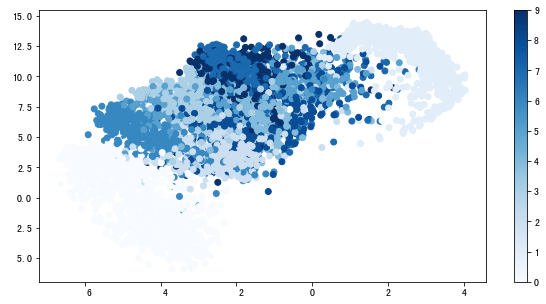

In [19]:
# plotting
encoded_imgs = encoder.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()

# 保存模型

In [20]:
from keras.models import load_model

In [ ]:
# save 保存
model.save('my_model.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
# load_model 加载模型
model = load_model('my_model.h5')

In [ ]:
#  model.to_json 保存完结构之后，然后再去加载这个json_string。
# save and load fresh network without trained weights
from keras.models import model_from_json
json_string = model.to_json()
model = model_from_json(json_string)

In [ ]:
# 另外还有其他保存模型并调用的方式，第一种是只保存权重而不保存模型的结构。
# save and load weights
model.save_weights('my_model_weights.h5')
model.load_weights('my_model_weights.h5')